## Sample drake passage transport

Notes:

- Drake passage definition: 70W
- Tiles 11 and 12 (0-indexed)
- Flipped coordinates: VVEL in those tiles is zonal velocity

In [2]:
import xarray as xr

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xmitgcm
from os.path import join,expanduser
import ecco_access as ea

# identify user's home directory
user_home_dir = expanduser('~')

In [4]:
ds = ea.ecco_podaac_to_xrdataset('ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4',grid='native',time_res='monthly',\
                                               StartDate='1992-01',EndDate='2017-12',\
                                               mode='s3_open_fsspec',\
                                               jsons_root_dir=join('/efs_ecco','mzz-jsons'))

In [5]:
ds_uvel = ds.UVEL

In [6]:
ds_uvel = ds_uvel.assign_coords({'XG':(['tile','j','i_g'],ds.XG.data),
                                'YG':(['tile','j','i_g'],ds.YG.data)})

In [7]:
ds_vvel = ds.VVEL.assign_coords({'XG':(['tile','j_g','i'],ds.XG.data),
                                'YG':(['tile','j_g','i'],ds.YG.data)})

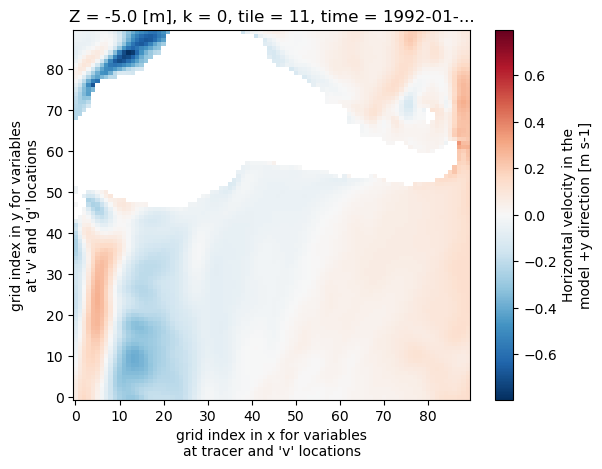

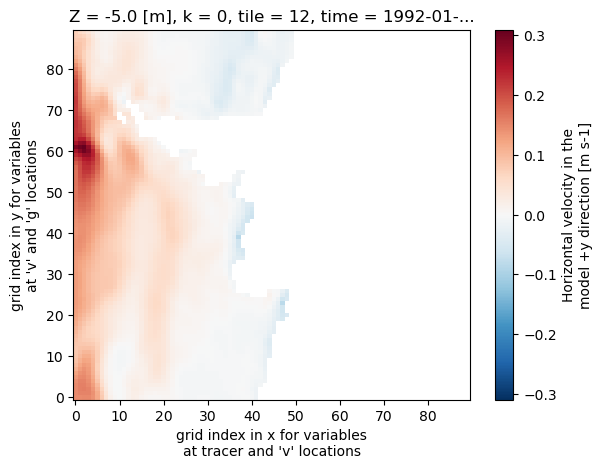

In [8]:
for i in range(11,13):
    ds_vvel[0,0,i].plot()
    plt.show()

In [9]:
# download data and open xarray dataset
curr_shortname = 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4'
grid = ea.ecco_podaac_to_xrdataset(curr_shortname,\
                                        StartDate='2017-01',EndDate='2017-12',\
                                        mode='download',\
                                        download_root_dir=join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC'))

created download directory /home/jovyan/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4

GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
DL Progress: 100%|########################| 1/1 [00:00<00:00, 18315.74it/s]

total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s
Time spent = 0.0021429061889648438 seconds




In [10]:
import xgcm
import ecco_v4_py as ecco

In [11]:
pt1,pt2 = ecco.get_section_endpoints('Drake Passage')
maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,ds)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

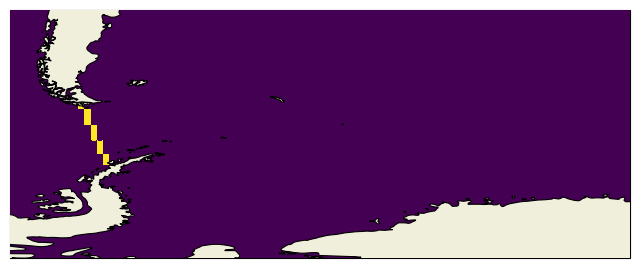

In [12]:
import cartopy.crs as ccrs
plt.figure(figsize=(8,8))
# use dx=.1, dy=.1 so that plot shows the osnap array as a thin
# line.  remember, plot_proj_to_latlon_grid first interpolates
# the model grid to lat-lon with grid spacing as dx, dy
P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC, maskC, \
                                cmap='viridis',\
                                projection_type='PlateCarree',\
                                lat_lim=45,dx=.1,dy=.1)
#ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
P[1].set_extent([-80, 20, -80, -40], crs=ccrs.PlateCarree())
plt.show()

In [13]:
# fname = '/efs_ecco/ifukumor/ECCO/EMU/tryout/mask.drake'

# byte_order = '>'
# mask = np.fromfile(fname, dtype=byte_order+'f4').reshape(1, 50, 13,90,90)

In [14]:
mask_xzarea = maskS * grid.dxG * grid.drF

In [15]:
ssh = ea.ecco_podaac_to_xrdataset('ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4',grid='native',time_res='monthly',\
                                               StartDate='1992-01',EndDate='2017-12',\
                                               mode='s3_open_fsspec',\
                                               jsons_root_dir=join('/efs_ecco','mzz-jsons'))

In [16]:
ssh=ssh.SSH

In [17]:
pt1 = (-56,-67)
pt2 = (-62,-56)

In [18]:
## i,j,tile of point 1

tile1 = 11
xc1 = grid.XC[11]
yc1 = grid.YC[11]

tile2 = 12
xc2 = grid.XC[tile2]
yc2 = grid.YC[tile2]

In [19]:
i1 = 88#np.argmin(np.abs(yc1[0,:].values-pt1[0]))
j1 = 60#np.argmin(np.abs(xc1[:,i1].values-pt1[1]))

i2 = 6#np.argmin(np.abs(yc2[0,:].values-pt2[0]))
j2 = 70#np.argmin(np.abs(xc2[:,i2].values-pt2[1]))

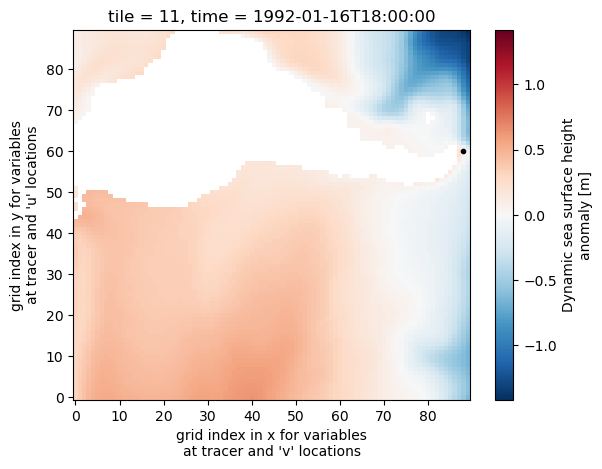

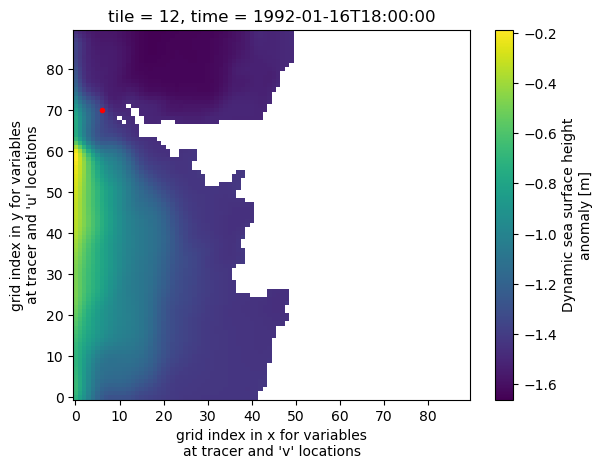

In [20]:
ssh[0,11].plot()
plt.plot(i1,j1,'.k')

plt.show()

ssh[0,12].plot()
plt.plot(i2,j2,'.r')

In [21]:
ssh_north = ssh.isel({'tile':tile1,'i':i1,'j':j1})

In [22]:
ssh_south = ssh.isel({'tile':tile2,'i':i2,'j':j2})

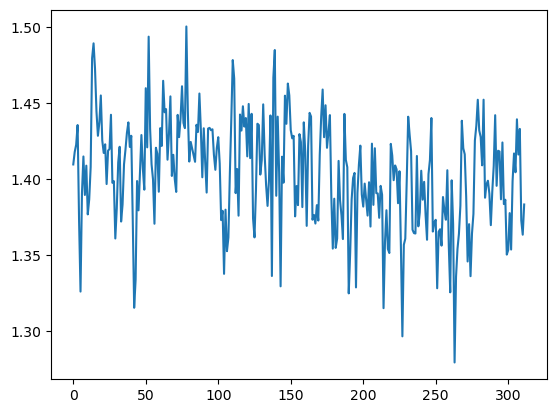

In [23]:
plt.plot(ssh_north-ssh_south)

In [24]:
!pip install haversine
from haversine import haversine

  Using cached haversine-2.8.1-py2.py3-none-any.whl.metadata (5.9 kB)
Using cached haversine-2.8.1-py2.py3-none-any.whl (7.7 kB)


In [25]:
rho = 1029
f = -1.2e-4# we can implement f = f(\phi) later if needed
g = 9.81

dy = haversine(pt1,pt2)*1000
## geostrophic velocity u = -g/f dSSH/dy

v_geo = -g/f *(ssh_north.values-ssh_south.values)/dy

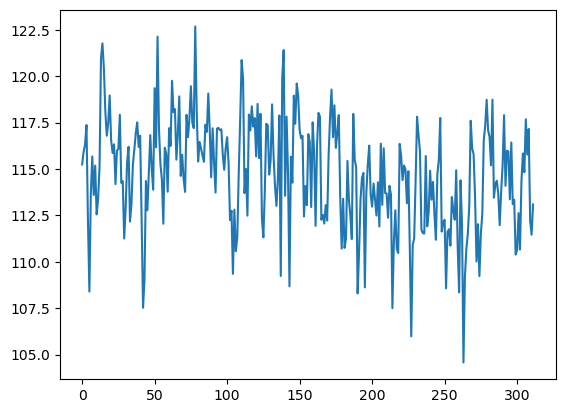

In [26]:
plt.plot(v_geo*dy*1000/1e6)

In [27]:
ds = ea.ecco_podaac_to_xrdataset('uvelmass',grid='native',time_res='monthly',\
                                               StartDate='1992-01',EndDate='2017-12',\
                                               mode='s3_open_fsspec',\
                                               jsons_root_dir=join('/efs_ecco','mzz-jsons'))

ShortName Options for query "uvelmass":
                  Variable Name     Description (units)

Option 1: ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4    UVEL,VVEL should not be used in volume flux calculations due to time-variable grid cell thicknesses (z* coordinates). Use UVELMASS,VVELMASS instead.
                  UVEL              Horizontal velocity in the model +x direction
                                    (m/s)
                  VVEL              Horizontal velocity in the model +y direction
                                    (m/s)
                  WVEL              Vertical velocity (m/s)

Option 2: ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4    *native grid,monthly means*
                  UVELMASS          Horizontal velocity in the model +x direction per
                                    unit area of the grid cell \'u\' face. Use this in
                                    volume flux calculations as it accounts for
                                    parti

Please select option [1-2]:  2


Using dataset with ShortName: ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4


In [28]:
ds = xr.merge((grid , ds))

In [29]:
drake_vol = ecco.calc_section_vol_trsp(ds,section_name='Drake Passage')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

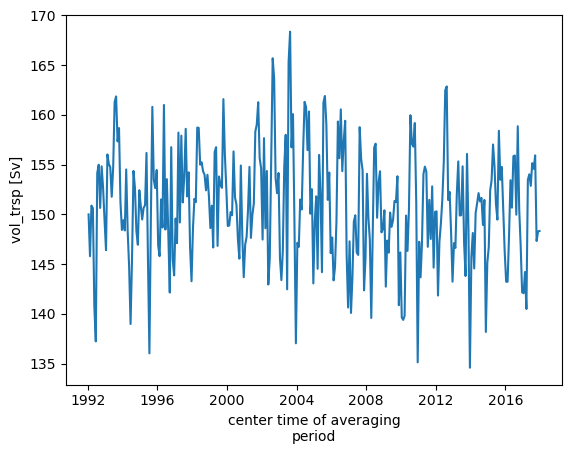

In [30]:
drake_vol.vol_trsp.plot()

In [32]:
vol_tsp_tot = drake_vol.vol_trsp.values
vol_tsp_geo = v_geo*dy*1000/1e6

In [34]:
vol_tsp_tot_normal = (vol_tsp_tot - np.mean(vol_tsp_tot))/np.std(vol_tsp_tot)
vol_tsp_geo_normal = (vol_tsp_geo - np.mean(vol_tsp_geo))/np.std(vol_tsp_geo)

0.7151001540419949


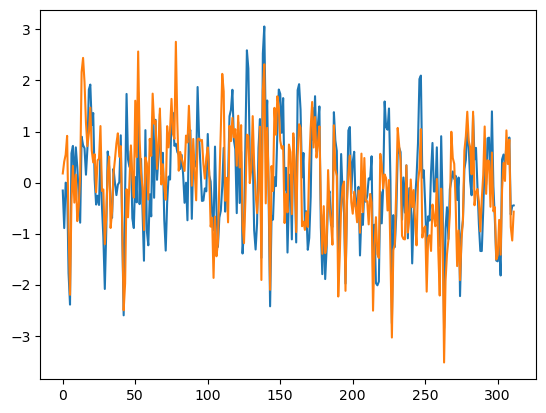

In [37]:
plt.plot(vol_tsp_tot_normal)
plt.plot(vol_tsp_geo_normal)
print(np.corrcoef(vol_tsp_tot_normal,vol_tsp_geo_normal)[0,1])

In [77]:
anom_tot = vol_tsp_tot_normal.reshape(12,26,order='F')
anom_tot = anom_tot - anom_tot.mean(axis=-1)[:,np.newaxis]
anom_tot = anom_tot.reshape(26*12)

In [78]:
anom_geo = vol_tsp_geo_normal.reshape(12,26,order='F')
anom_geo = anom_geo - anom_geo.mean(axis=-1)[:,np.newaxis]
anom_geo = anom_geo.reshape(26*12)

0.7809480253595225


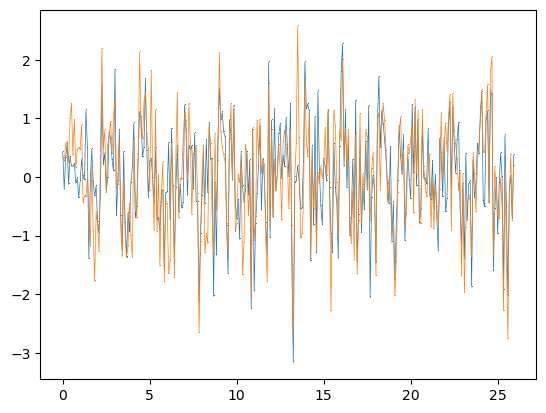

In [90]:
plt.plot(np.arange(312)/12,anom_tot,',-',lw=0.5)
plt.plot(np.arange(312)/12,anom_geo,',-',lw=0.5)
print(np.corrcoef(anom_tot,anom_geo)[0,1])